### Imports

In [7]:
import csv
import re
import os
import pandas as pd
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import Choropleth
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

## Leitura do ficheiro

In [8]:
p = Path.cwd()
data_folder = p.parent.parent / "data"
shape_folder = p.parent.parent / "shape"

In [9]:
file = data_folder / "QuebrasJuntoInc.xlsx"
QuebrasFinal = pd.read_excel(file)
QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,55,828.0,"0,0029345","0,0000443","0,0024563",...,157.9,0.000000,10.7,17.4,2.6,NaN,NaN,NaN,NaN,0.0
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,163,549.0,"0,0029335","0,0001770","0,0165009",...,260.2,1.000000,10.6,13.8,6.2,249.0,270.0,2.8,8.1,0.0
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,596,3459.0,"0,0192281","0,0002655","0,0359047",...,117.9,0.800000,14.0,14.8,12.9,197.0,180.0,3.9,14.4,4.0
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,178,102.0,"0,0000000","0,0000000","0,0000000",...,156.4,0.923077,12.4,15.1,9.1,288.0,225.0,3.6,13.9,13.2
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,119,1731.0,"0,0044221","0,0001549","0,0100377",...,467.9,1.000000,4.9,7.8,2.2,137.0,118.0,4.1,15.4,15.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7300,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,220,2.0,0,0,0,...,141.7,1.000000,10.3,14.3,6.3,NaN,NaN,NaN,NaN,0.0
7301,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,92,1.0,0,0,0,...,134.6,0.000000,16.4,20.6,14.8,NaN,NaN,NaN,NaN,NaN
7302,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,121,1.0,0,0,0,...,134.6,0.000000,17.9,22.6,14.6,NaN,NaN,NaN,NaN,8.1
7303,EDPD_2017_NOV_T_65,Almeirim,2017-11-03,BT,Descarga Atmosférica Directa,154,1.0,0,0,0,...,175.1,1.000000,15.0,20.8,12.8,186.0,186.0,2.5,11.0,NaN


In [10]:
# Remover colunas desnecessárias
columnsRemove = ['Qualidade de Energia Elétrica', 'Qualidade de Serviço Comercial', 'Fundamentação']
QuebrasFinal = QuebrasFinal.drop(columns=columnsRemove)

# Substituir as vírgulas por pontos nas colunas supostamente numéricas
colunas_string = QuebrasFinal.iloc[:, 5:33].select_dtypes(include=['object']).columns
QuebrasFinal[colunas_string] = QuebrasFinal[colunas_string].replace(',', '.', regex=True)

QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,55,828.0,0.0029345,0.0000443,0.0024563,...,157.9,0.000000,10.7,17.4,2.6,NaN,NaN,NaN,NaN,0.0
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,163,549.0,0.0029335,0.0001770,0.0165009,...,260.2,1.000000,10.6,13.8,6.2,249.0,270.0,2.8,8.1,0.0
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,596,3459.0,0.0192281,0.0002655,0.0359047,...,117.9,0.800000,14.0,14.8,12.9,197.0,180.0,3.9,14.4,4.0
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,178,102.0,0.0000000,0.0000000,0.0000000,...,156.4,0.923077,12.4,15.1,9.1,288.0,225.0,3.6,13.9,13.2
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,119,1731.0,0.0044221,0.0001549,0.0100377,...,467.9,1.000000,4.9,7.8,2.2,137.0,118.0,4.1,15.4,15.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7300,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,220,2.0,0,0,0,...,141.7,1.000000,10.3,14.3,6.3,NaN,NaN,NaN,NaN,0.0
7301,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,92,1.0,0,0,0,...,134.6,0.000000,16.4,20.6,14.8,NaN,NaN,NaN,NaN,NaN
7302,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,121,1.0,0,0,0,...,134.6,0.000000,17.9,22.6,14.6,NaN,NaN,NaN,NaN,8.1
7303,EDPD_2017_NOV_T_65,Almeirim,2017-11-03,BT,Descarga Atmosférica Directa,154,1.0,0,0,0,...,175.1,1.000000,15.0,20.8,12.8,186.0,186.0,2.5,11.0,NaN


In [11]:
QuebrasFinal.dtypes

Código do Relatório          object
Concelho                     object
Data do incidente            object
Nível de Tensão              object
Causa do incidente           object
Duração incidente (min)      object
N.º clientes afetados       float64
TIEPI MT (min)               object
SAIFI MT (#)                 object
SAIDI MT (min)               object
END (MWh)                    object
SAIFI BT (#)                 object
SAIDI BT (min)               object
Decisão                      object
Dia                           int64
Mês                           int64
Ano                           int64
Distrito                     object
Densidade Populacional      float64
População Residente           int64
Setor Primário                int64
Setor Secundário              int64
Setor Terciário               int64
Indice de Envelhecimento    float64
Rural                       float64
T_MED                       float64
T_MAX                       float64
T_MIN                       

In [12]:
# Lista das colunas a serem convertidas
colunas_para_converter = ['Duração incidente (min)', 'TIEPI MT (min)', 'SAIFI MT (#)', 
                          'SAIDI MT (min)', 'END (MWh)', 'SAIFI BT (#)', 'SAIDI BT (min)']

# Converter as colunas para o tipo float
QuebrasFinal[colunas_para_converter] = QuebrasFinal[colunas_para_converter].apply(pd.to_numeric, errors='coerce')


## Estandardizar/Normalizar os dados

In [13]:
# Selecionar as colunas numéricas
colunas_numericas = QuebrasFinal.select_dtypes(include=[np.number]).columns
colunas_numericas

Index(['Duração incidente (min)', 'N.º clientes afetados', 'TIEPI MT (min)',
       'SAIFI MT (#)', 'SAIDI MT (min)', 'END (MWh)', 'SAIFI BT (#)',
       'SAIDI BT (min)', 'Dia', 'Mês', 'Ano', 'Densidade Populacional',
       'População Residente', 'Setor Primário', 'Setor Secundário',
       'Setor Terciário', 'Indice de Envelhecimento', 'Rural', 'T_MED',
       'T_MAX', 'T_MIN', 'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD'],
      dtype='object')

In [14]:
# Escolher o que queres
_ = False

if _ == True:
    # Criar o objeto do normalizador Min-Max
    scaler = MinMaxScaler()
    
    # Normalizar as colunas numéricas
    QuebrasFinal[colunas_numericas] = scaler.fit_transform(QuebrasFinal[colunas_numericas])

else:
    # Criar o objeto do estandardizador
    scaler = StandardScaler()
    
    # Estandardizar as colunas numéricas
    QuebrasFinal[colunas_numericas] = scaler.fit_transform(QuebrasFinal[colunas_numericas])

# Resultado final
QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,-0.167430,-0.035849,-0.025291,-0.027507,-0.026427,...,-0.466877,-1.684053,-1.009103,-0.663530,-1.766912,NaN,NaN,NaN,NaN,-0.380286
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,-0.023458,-0.046206,-0.025292,-0.020875,-0.015301,...,0.564873,0.703961,-1.027227,-1.174879,-1.049541,0.301675,0.351434,-0.139841,-0.598378,-0.380286
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,0.553762,0.061818,-0.008440,-0.016452,0.000071,...,-0.870298,0.226358,-0.411014,-1.032837,0.285565,-0.177013,-0.552665,0.657334,1.193837,0.146958
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,-0.003462,-0.062799,-0.028326,-0.029721,-0.028373,...,-0.482005,0.520268,-0.700997,-0.990225,-0.471659,0.660690,-0.100615,0.439923,1.051597,1.359619
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,-0.082113,-0.002328,-0.023752,-0.021980,-0.020421,...,2.659638,0.703961,-2.060289,-2.027127,-1.846620,-0.729344,-1.175489,0.802275,1.478315,1.715509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7300,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,0.052527,-0.066512,-0.028326,-0.029721,-0.028373,...,-0.630262,0.703961,-1.081598,-1.103858,-1.029614,NaN,NaN,NaN,NaN,-0.380286
7301,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,-0.118106,-0.066549,-0.028326,-0.029721,-0.028373,...,-0.701870,-1.684053,0.023960,-0.208997,0.664177,NaN,NaN,NaN,NaN,NaN
7302,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,-0.079447,-0.066549,-0.028326,-0.029721,-0.028373,...,-0.701870,-1.684053,0.295818,0.075085,0.624323,NaN,NaN,NaN,NaN,0.687383
7303,EDPD_2017_NOV_T_65,Almeirim,2017-11-03,BT,Descarga Atmosférica Directa,-0.035456,-0.066549,-0.028326,-0.029721,-0.028373,...,-0.293405,0.703961,-0.229775,-0.180589,0.265638,-0.278273,-0.492392,-0.357252,0.226609,NaN


## Imputação dos dados

In [15]:
# Criar o objeto do imputador por regressão
imputer_mice = IterativeImputer()

# Aplicar o método MICE para imputar os valores ausentes em todas as colunas numéricas
QuebrasFinal[colunas_numericas] = imputer_mice.fit_transform(QuebrasFinal[colunas_numericas])

# Resultado final
QuebrasFinal


C:\Users\diogo\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,-0.167430,-0.035849,-0.025291,-0.027507,-0.026427,...,-0.466877,-1.684053,-1.009103,-0.663530,-1.766912,-0.170715,-0.001784,-0.139797,-0.094998,-0.380286
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,-0.023458,-0.046206,-0.025292,-0.020875,-0.015301,...,0.564873,0.703961,-1.027227,-1.174879,-1.049541,0.301675,0.351434,-0.139841,-0.598378,-0.380286
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,0.553762,0.061818,-0.008440,-0.016452,0.000071,...,-0.870298,0.226358,-0.411014,-1.032837,0.285565,-0.177013,-0.552665,0.657334,1.193837,0.146958
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,-0.003462,-0.062799,-0.028326,-0.029721,-0.028373,...,-0.482005,0.520268,-0.700997,-0.990225,-0.471659,0.660690,-0.100615,0.439923,1.051597,1.359619
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,-0.082113,-0.002328,-0.023752,-0.021980,-0.020421,...,2.659638,0.703961,-2.060289,-2.027127,-1.846620,-0.729344,-1.175489,0.802275,1.478315,1.715509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7300,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,0.052527,-0.066512,-0.028326,-0.029721,-0.028373,...,-0.630262,0.703961,-1.081598,-1.103858,-1.029614,-0.290553,-0.263786,-0.217849,-0.319109,-0.380286
7301,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,-0.118106,-0.066549,-0.028326,-0.029721,-0.028373,...,-0.701870,-1.684053,0.023960,-0.208997,0.664177,-0.149299,-0.107256,-0.271951,-0.228287,0.355803
7302,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,-0.079447,-0.066549,-0.028326,-0.029721,-0.028373,...,-0.701870,-1.684053,0.295818,0.075085,0.624323,-0.141388,-0.111701,-0.262819,-0.069782,0.687383
7303,EDPD_2017_NOV_T_65,Almeirim,2017-11-03,BT,Descarga Atmosférica Directa,-0.035456,-0.066549,-0.028326,-0.029721,-0.028373,...,-0.293405,0.703961,-0.229775,-0.180589,0.265638,-0.278273,-0.492392,-0.357252,0.226609,0.601223


In [16]:
QuebrasFinal[QuebrasFinal.isna().any(axis=1)]

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD


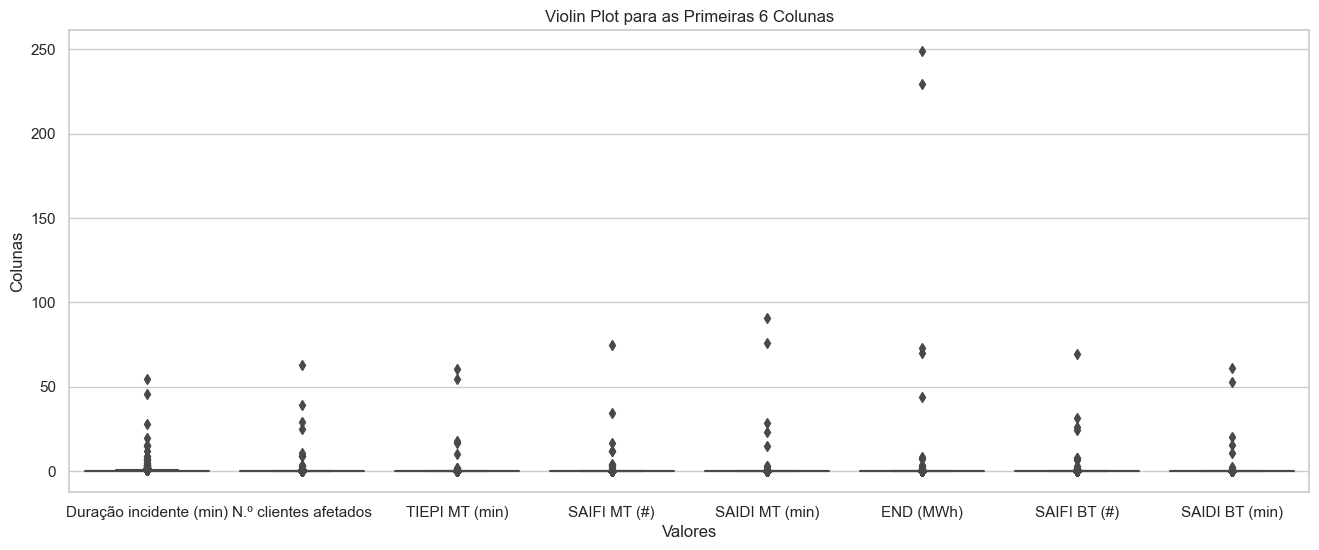

In [17]:
sns.set(style="whitegrid")

# Selecionar apenas as primeiras 6 colunas
subset_quebras_final = QuebrasFinal.iloc[:, 5:13]

# Plotar violin plot para as primeiras 6 colunas
plt.figure(figsize=(16, 6))
sns.boxplot(data=subset_quebras_final)
plt.title("Violin Plot para as Primeiras 6 Colunas")
plt.xlabel("Valores")
plt.ylabel("Colunas")
plt.show()

## Modelling

In [6]:
# Selecionar apenas as colunas numéricas
colunas_numericas = QuebrasFinal.select_dtypes(include=[np.number])

# Valores de k que você deseja testar
k_values = range(2, 7)

# Lista para armazenar os valores de silhueta média
silhouette_scores = []

# Iterar sobre os valores de k
for k in k_values:
    # Criar o modelo de clustering K-Means
    kmeans = KMeans(n_clusters=k, random_state=42)
    # Treinar o modelo nos dados
    kmeans.fit(colunas_numericas)
    # Obter as etiquetas de cluster para cada ponto
    labels = kmeans.labels_
    # Calcular o score de silhueta
    silhouette_avg = silhouette_score(colunas_numericas, labels)
    # Armazenar o score de silhueta na lista
    silhouette_scores.append(silhouette_avg)

# Plotar o gráfico do Método do Cotovelo
plt.plot(k_values, silhouette_scores, 'bx-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhueta Média')
plt.title('Método da Silhueta para Determinar k (Variáveis Numéricas)')
plt.show()


ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

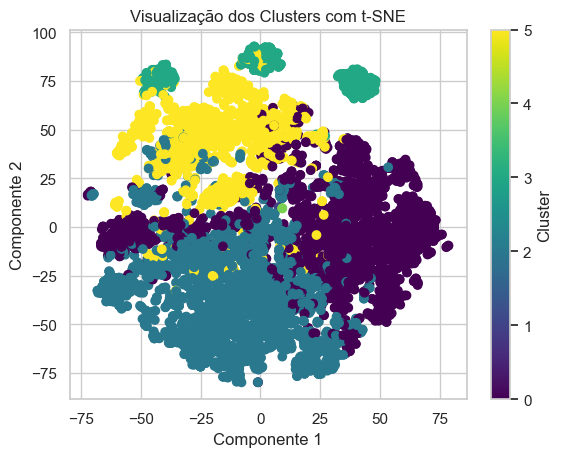

In [13]:
# Reduzir a dimensionalidade dos dados para 2 dimensões usando t-SNE
tsne = TSNE(n_components=2, random_state=69)
data_2d = tsne.fit_transform(colunas_numericas)

# Plotar os pontos em um gráfico de dispersão, colorindo-os de acordo com os clusters
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=labels, cmap='viridis')
plt.title('Visualização dos Clusters com t-SNE')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.colorbar(label='Cluster')
plt.show()

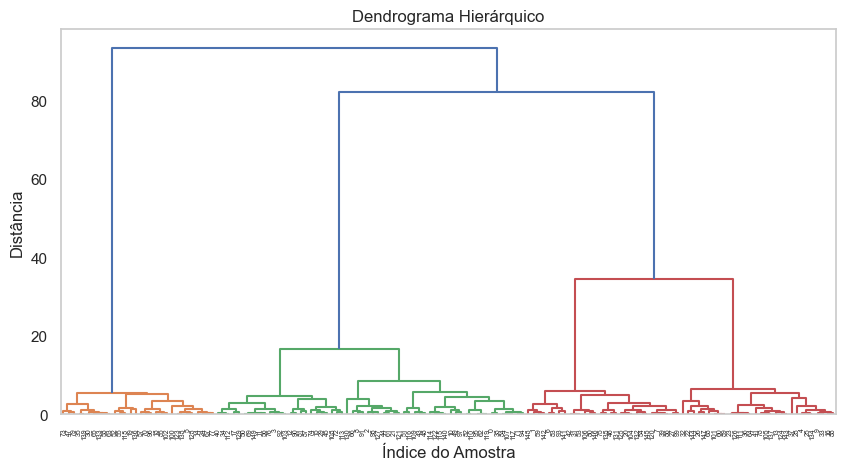

In [14]:
# Gerar dados de exemplo
X, _ = make_blobs(n_samples=150, centers=5, random_state=42)

# Executar o algoritmo de clustering hierárquico
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model.fit(X)

# Função para plotar o dendrograma
def plot_dendrogram(model, **kwargs):
    # Calcula o layout do dendrograma
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # folha
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plota o dendrograma
    dendrogram(linkage_matrix, **kwargs)

# Plotando o dendrograma
plt.figure(figsize=(10, 5))
plt.title('Dendrograma Hierárquico')
plot_dendrogram(model)
plt.xlabel('Índice do Amostra')
plt.ylabel('Distância')
plt.grid(False)
plt.show()

In [15]:
# Inicialize o modelo Agglomerative Clustering com o número desejado de clusters
n_clusters = 3  # Defina o número de clusters desejado
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)

# Ajuste o modelo aos dados
agg_clustering.fit(colunas_numericas)

# Obtenha as etiquetas de cluster para cada amostra
cluster_labels = agg_clustering.labels_

# Adicione as etiquetas de cluster ao DataFrame QuebrasFinal
colunas_numericas['Cluster_Agglomerative'] = cluster_labels

Silhouette média para o modelo Agglomerative Clustering: 0.22554655215398856


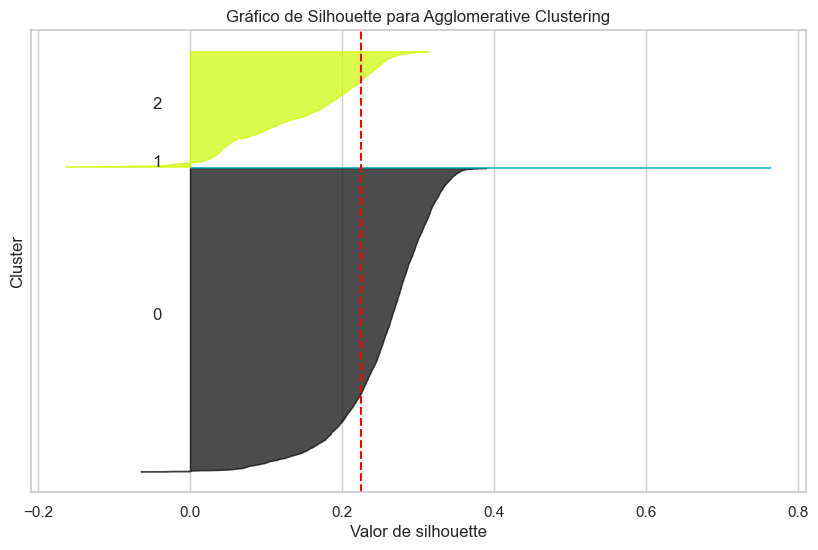

In [16]:
# Calcule a silhouette média para o modelo
silhouette_avg = silhouette_score(colunas_numericas, cluster_labels)
print("Silhouette média para o modelo Agglomerative Clustering:", silhouette_avg)

# Calcule a silhouette para cada amostra
sample_silhouette_values = silhouette_samples(colunas_numericas, cluster_labels)

# Crie um gráfico de barras para mostrar a silhouette para cada amostra
plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(n_clusters):
    # Agregue a silhouette para amostras pertencentes ao cluster i
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / n_clusters)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Etiqueta do cluster no meio
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Calcule o próximo y_lower para o próximo gráfico
    y_lower = y_upper + 10  

plt.title("Gráfico de Silhouette para Agglomerative Clustering")
plt.xlabel("Valor de silhouette")
plt.ylabel("Cluster")
plt.axvline(x=silhouette_avg, color="red", linestyle="--")  # Linha para indicar a silhouette média
plt.yticks([])  # Limpe os yticks
plt.show()


In [17]:
colunas_numericas

,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),END (MWh),SAIFI BT (#),SAIDI BT (min),Dia,Mês,...,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD,Cluster_Agglomerative
0,-0.167430,-0.035849,-0.025291,-0.027507,-0.026427,-0.027949,-0.021644,-0.022375,-1.566296,-1.601598,...,-1.684053,-1.009103,-0.663530,-1.766912,-0.170715,-0.001784,-0.139797,-0.094998,-0.380286,2
1,-0.023458,-0.046206,-0.025292,-0.020875,-0.015301,-0.027953,-0.027700,-0.021755,-1.566296,-1.601598,...,0.703961,-1.027227,-1.174879,-1.049541,0.301675,0.351434,-0.139841,-0.598378,-0.380286,0
2,0.553762,0.061818,-0.008440,-0.016452,0.000071,0.042431,0.001999,0.013339,-1.334526,-1.601598,...,0.226358,-0.411014,-1.032837,0.285565,-0.177013,-0.552665,0.657334,1.193837,0.146958,0
3,-0.003462,-0.062799,-0.028326,-0.029721,-0.028373,-0.040624,-0.037415,-0.025634,-1.218641,-1.601598,...,0.520268,-0.700997,-0.990225,-0.471659,0.660690,-0.100615,0.439923,1.051597,1.359619,0
4,-0.082113,-0.002328,-0.023752,-0.021980,-0.020421,-0.021523,-0.032763,-0.026085,-0.755101,-1.601598,...,0.703961,-2.060289,-2.027127,-1.846620,-0.729344,-1.175489,0.802275,1.478315,1.715509,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7300,0.052527,-0.066512,-0.028326,-0.029721,-0.028373,-0.040624,-0.039628,-0.027713,1.562600,1.498721,...,0.703961,-1.081598,-1.103858,-1.029614,-0.290553,-0.263786,-0.217849,-0.319109,-0.380286,0
7301,-0.118106,-0.066549,-0.028326,-0.029721,-0.028373,-0.040624,-0.039628,-0.027754,-1.450411,1.498721,...,-1.684053,0.023960,-0.208997,0.664177,-0.149299,-0.107256,-0.271951,-0.228287,0.355803,2
7302,-0.079447,-0.066549,-0.028326,-0.029721,-0.028373,-0.040624,-0.039628,-0.027736,0.867289,1.498721,...,-1.684053,0.295818,0.075085,0.624323,-0.141388,-0.111701,-0.262819,-0.069782,0.687383,2
7303,-0.035456,-0.066549,-0.028326,-0.029721,-0.028373,-0.040624,-0.035917,-0.024709,-1.450411,1.498721,...,0.703961,-0.229775,-0.180589,0.265638,-0.278273,-0.492392,-0.357252,0.226609,0.601223,0


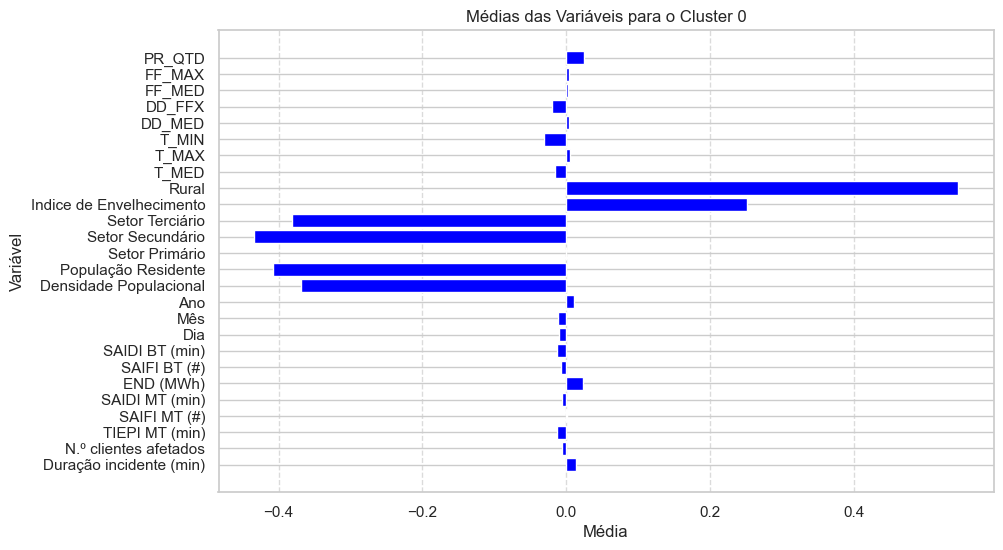

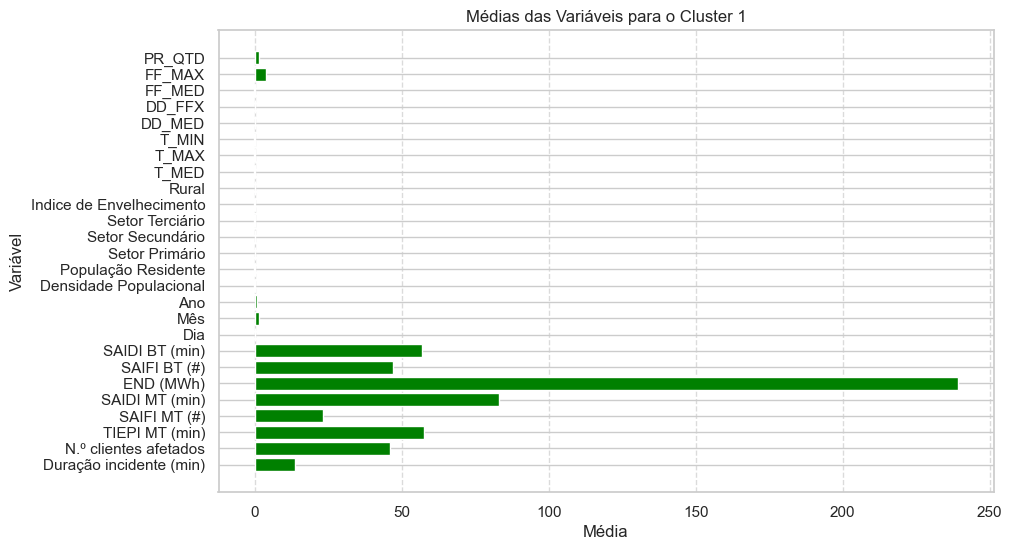

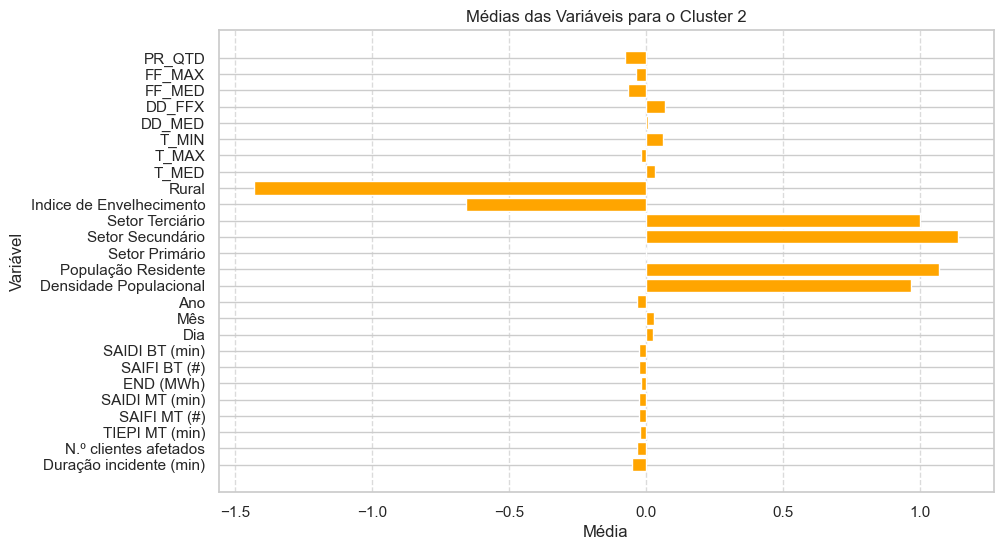

In [18]:
# Agrupar os dados por cluster e calcular as médias
cluster_means = colunas_numericas.groupby('Cluster_Agglomerative').mean()

# Definir cores para os clusters
colors = ['blue', 'green', 'orange', 'red']

# Plotar os gráficos de barras para cada cluster
for i, cluster in enumerate(cluster_means.index):
    cluster_data = cluster_means.loc[cluster]
    plt.figure(figsize=(10, 6))
    plt.barh(cluster_data.index, cluster_data.values, color=colors[i])
    plt.title(f'Médias das Variáveis para o Cluster {cluster}')
    plt.xlabel('Média')
    plt.ylabel('Variável')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

In [19]:
# Supondo que 'clusters' seja a coluna de clusters em QuebrasFinal
clusters = colunas_numericas['Cluster_Agglomerative']

# Adicionando a coluna de clusters ao DataFrame Quebras
QuebrasFinal['Cluster_Agglomerative'] = clusters

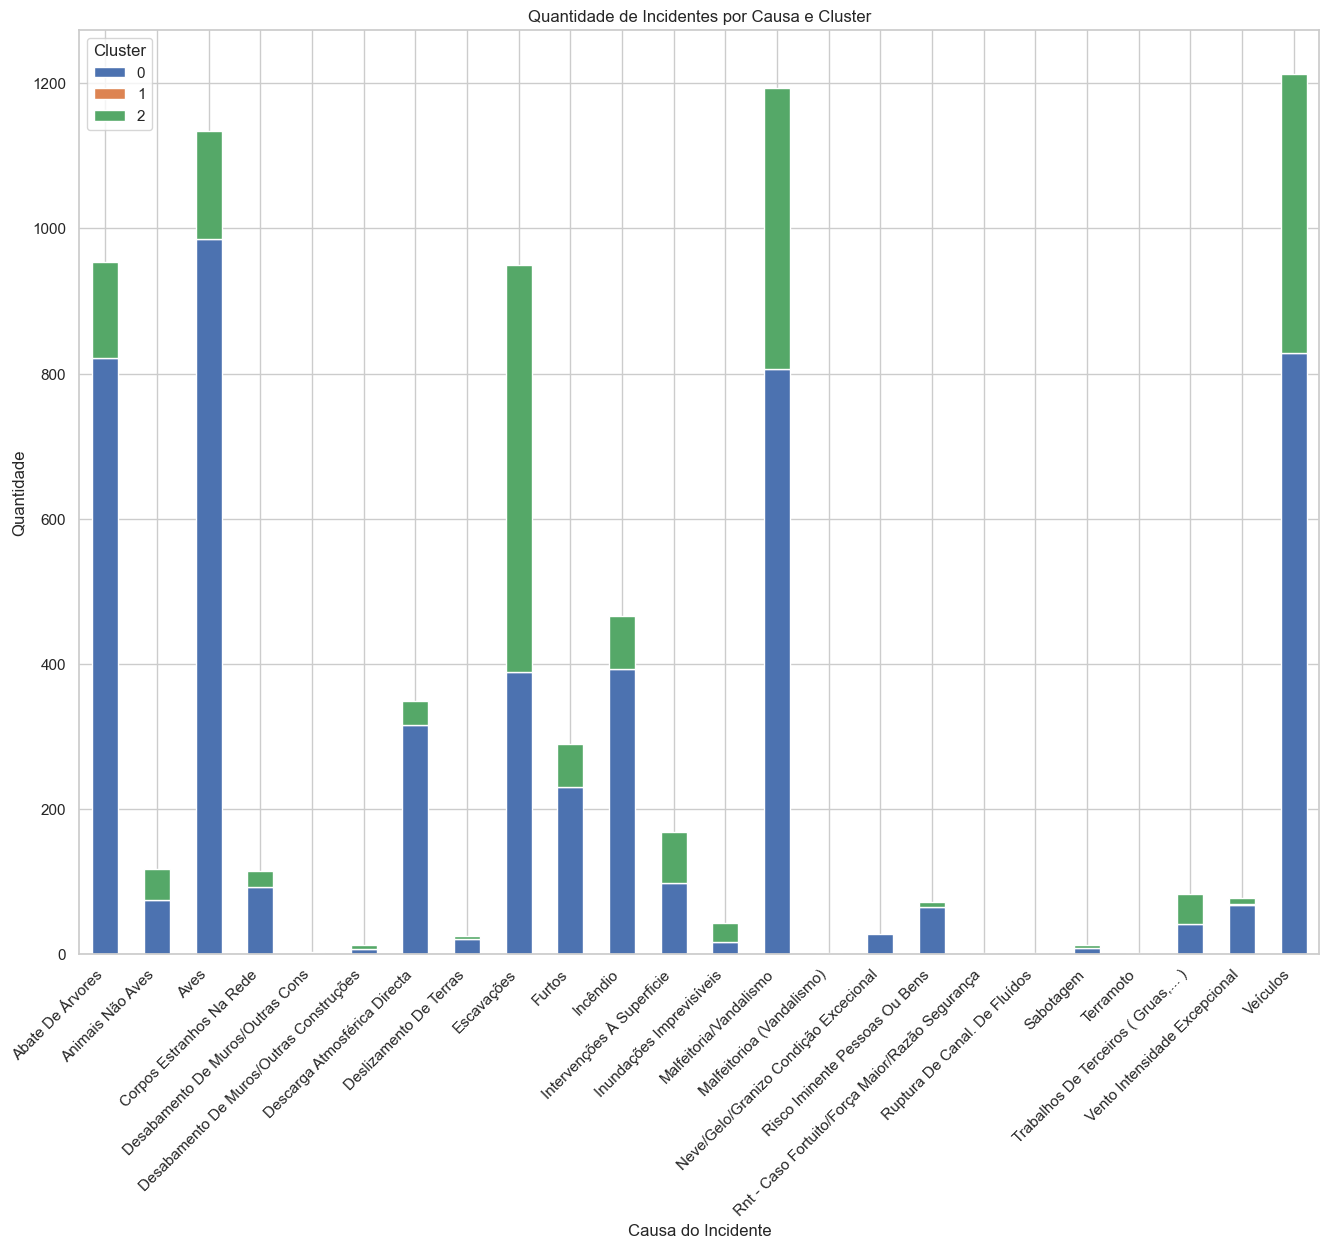

In [20]:
# Agrupar os dados por causa do incidente e cluster e contar o número de ocorrências em cada grupo
causa_cluster_counts = QuebrasFinal.groupby(['Causa do incidente', 'Cluster_Agglomerative']).size().unstack(fill_value=0)

# Plotar o gráfico de barras empilhadas para cada causa do incidente
causa_cluster_counts.plot(kind='bar', stacked=True, figsize=(16, 12))
plt.title('Quantidade de Incidentes por Causa e Cluster')
plt.xlabel('Causa do Incidente')
plt.ylabel('Quantidade')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cluster')
plt.show()

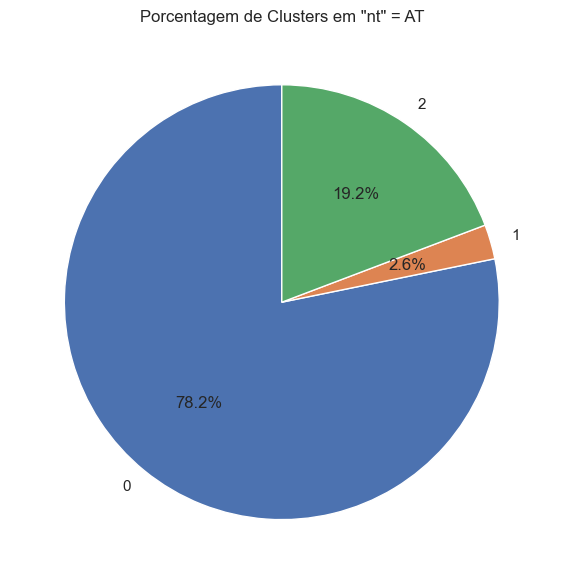

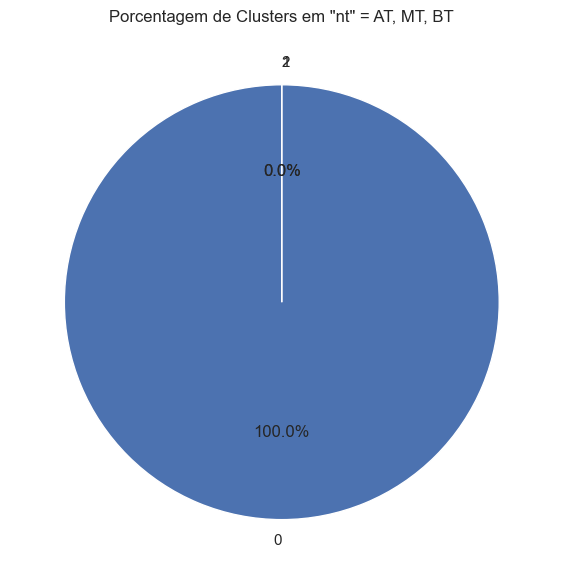

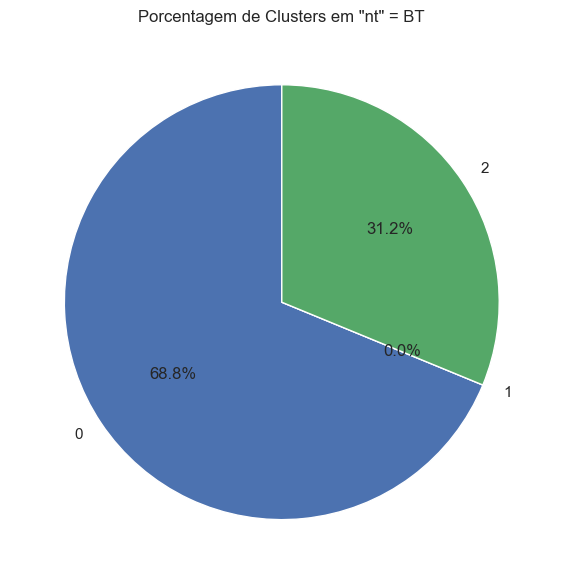

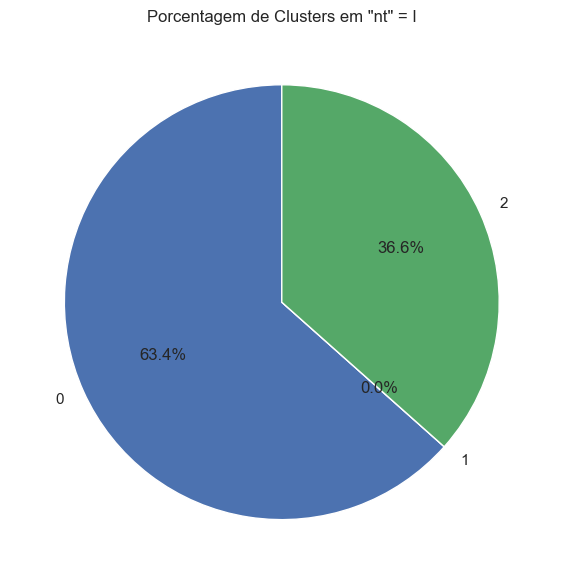

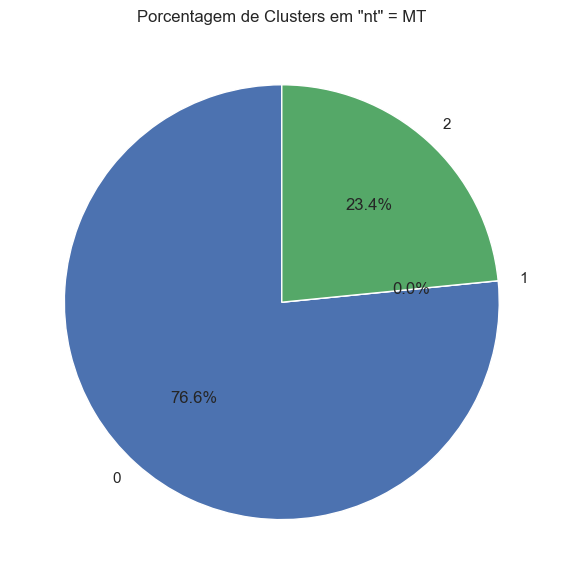

In [21]:
# Agrupar os dados por 'nt' e 'Cluster_Agglomerative' e contar o número de ocorrências em cada grupo
nt_cluster_counts = QuebrasFinal.groupby(['Nível de Tensão', 'Cluster_Agglomerative']).size().unstack(fill_value=0)

# Calcular a porcentagem de ocorrências de cada cluster para cada valor de 'nt'
nt_cluster_percentages = nt_cluster_counts.div(nt_cluster_counts.sum(axis=1), axis=0) * 100

# Plotar gráficos circulares para a porcentagem de clusters em cada valor de 'nt'
for nt_value, nt_cluster_percentage in nt_cluster_percentages.iterrows():
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.pie(nt_cluster_percentage, labels=nt_cluster_percentage.index, autopct='%1.1f%%', startangle=90)
    ax.set_title(f'Porcentagem de Clusters em "nt" = {nt_value}')
    plt.tight_layout()
    # plt.savefig(f'Porcentagem_Clusters_nt_{nt_value}.svg')
    plt.show()


In [22]:
# Criar a tabela pivô
pivot_table = QuebrasFinal.pivot_table(index='Concelho', columns='Cluster_Agglomerative', aggfunc='size', fill_value=0)

# Renomear as colunas
pivot_table.columns = ['Cluster_' + str(col) for col in pivot_table.columns]

# Exibir a tabela pivô
pivot_table
pivot_table['Cluster_2'].idxmax()

'Lisboa'

In [23]:
file_path = shape_folder / "concelhos.shp"
Concelho = gpd.read_file(file_path)
Concelho.rename(columns={'NAME_1': 'Distrito'}, inplace=True)
Concelho.rename(columns={'NAME_2': 'Concelho'}, inplace=True)
Concelho["Concelho"] = Concelho["Concelho"].str.title()
Concelho = Concelho[~Concelho['Distrito'].isin(['Azores', 'Madeira'])]
Concelho

,ID_0,ISO,NAME_0,ID_1,Distrito,ID_2,Concelho,HASC_2,CCN_2,CCA_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2,geometry
0,182,PRT,Portugal,1,Évora,1,Évora,PT.EV.EV,0,0705,Concelho,Municipality,None,None,"POLYGON ((-7.79291 38.76507, -7.79287 38.76506..."
1,182,PRT,Portugal,1,Évora,2,Alandroal,PT.EV.AL,0,0701,Concelho,Municipality,None,None,"POLYGON ((-7.25937 38.77351, -7.25921 38.77343..."
2,182,PRT,Portugal,1,Évora,3,Arraiolos,PT.EV.AR,0,0702,Concelho,Municipality,None,None,"POLYGON ((-7.88611 38.92495, -7.88580 38.92472..."
3,182,PRT,Portugal,1,Évora,4,Borba,PT.EV.BO,0,0703,Concelho,Municipality,None,None,"POLYGON ((-7.46362 38.92344, -7.46344 38.92329..."
4,182,PRT,Portugal,1,Évora,5,Estremoz,PT.EV.ES,0,0704,Concelho,Municipality,None,None,"POLYGON ((-7.52770 39.00080, -7.52765 39.00066..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,182,PRT,Portugal,20,Viseu,302,Tarouca,PT.VI.TR,0,1820,Concelho,Municipality,None,None,"POLYGON ((-7.72591 41.08079, -7.72442 41.08028..."
304,182,PRT,Portugal,20,Viseu,303,Tondela,PT.VI.TO,0,1821,Concelho,Municipality,None,None,"POLYGON ((-8.12772 40.64028, -8.12751 40.64027..."
305,182,PRT,Portugal,20,Viseu,304,Vila Nova De Paiva,PT.VI.VP,0,1822,Concelho,Municipality,None,None,"POLYGON ((-7.77933 40.93439, -7.77835 40.93436..."
306,182,PRT,Portugal,20,Viseu,305,Viseu,PT.VI.VS,0,1823,Concelho,Municipality,None,None,"POLYGON ((-7.80686 40.83789, -7.80653 40.83787..."


In [24]:
Bilada = set(pivot_table.index) - set(Concelho["Concelho"])
Bilada

{'Guimarães', 'Tavira'}

In [25]:
Freguesias_com_clusters = Concelho.merge(pivot_table, left_on='Concelho', right_index=True, how="left")
Freguesias_com_clusters.fillna(0, inplace=True)
Freguesias_com_clusters

,ID_0,ISO,NAME_0,ID_1,Distrito,ID_2,Concelho,HASC_2,CCN_2,CCA_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2,geometry,Cluster_0,Cluster_1,Cluster_2
0,182,PRT,Portugal,1,Évora,1,Évora,PT.EV.EV,0,0705,Concelho,Municipality,0,0,"POLYGON ((-7.79291 38.76507, -7.79287 38.76506...",53.0,0.0,1.0
1,182,PRT,Portugal,1,Évora,2,Alandroal,PT.EV.AL,0,0701,Concelho,Municipality,0,0,"POLYGON ((-7.25937 38.77351, -7.25921 38.77343...",17.0,0.0,0.0
2,182,PRT,Portugal,1,Évora,3,Arraiolos,PT.EV.AR,0,0702,Concelho,Municipality,0,0,"POLYGON ((-7.88611 38.92495, -7.88580 38.92472...",21.0,0.0,0.0
3,182,PRT,Portugal,1,Évora,4,Borba,PT.EV.BO,0,0703,Concelho,Municipality,0,0,"POLYGON ((-7.46362 38.92344, -7.46344 38.92329...",7.0,0.0,0.0
4,182,PRT,Portugal,1,Évora,5,Estremoz,PT.EV.ES,0,0704,Concelho,Municipality,0,0,"POLYGON ((-7.52770 39.00080, -7.52765 39.00066...",18.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,182,PRT,Portugal,20,Viseu,302,Tarouca,PT.VI.TR,0,1820,Concelho,Municipality,0,0,"POLYGON ((-7.72591 41.08079, -7.72442 41.08028...",7.0,0.0,0.0
304,182,PRT,Portugal,20,Viseu,303,Tondela,PT.VI.TO,0,1821,Concelho,Municipality,0,0,"POLYGON ((-8.12772 40.64028, -8.12751 40.64027...",38.0,0.0,0.0
305,182,PRT,Portugal,20,Viseu,304,Vila Nova De Paiva,PT.VI.VP,0,1822,Concelho,Municipality,0,0,"POLYGON ((-7.77933 40.93439, -7.77835 40.93436...",6.0,0.0,0.0
306,182,PRT,Portugal,20,Viseu,305,Viseu,PT.VI.VS,0,1823,Concelho,Municipality,0,0,"POLYGON ((-7.80686 40.83789, -7.80653 40.83787...",82.0,0.0,0.0


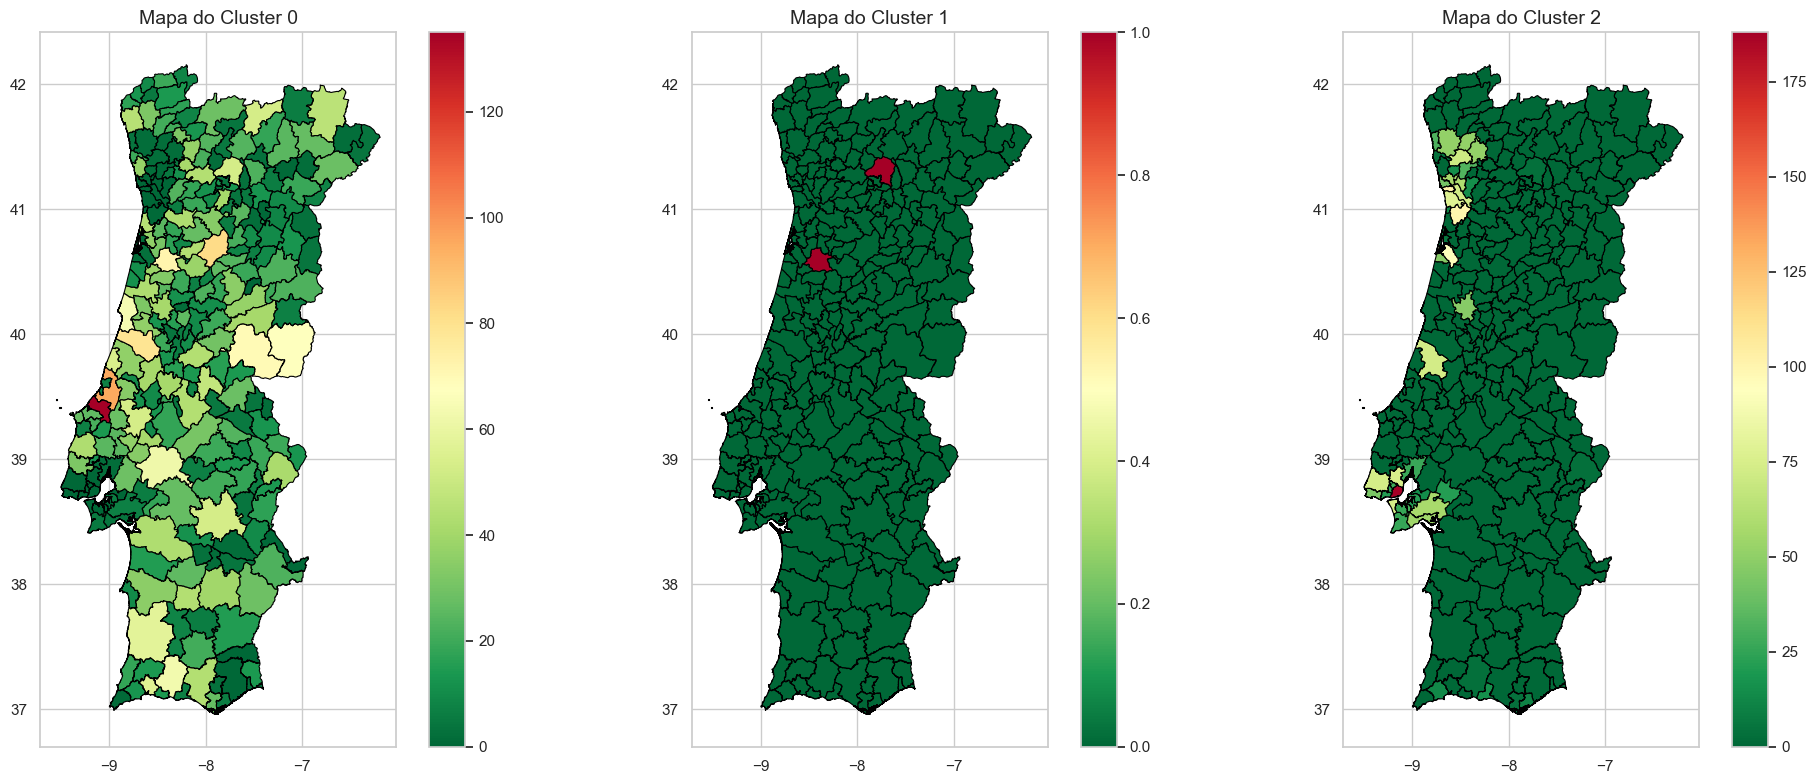

In [27]:
# Configurar a figura e os eixos para a grade de subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

# Iterar sobre cada cluster e plotar o mapa correspondente
for i, cluster in enumerate(['Cluster_0', 'Cluster_1', 'Cluster_2']):
    # Plotar o mapa das freguesias para o cluster atual
    Freguesias_com_clusters.plot(column=cluster, cmap='RdYlGn_r', linewidth=0.8, edgecolor='black', ax=axs[i], legend=True)
    
    # Adicionar título para cada subplot
    axs[i].set_title(f'Mapa do Cluster {i}', fontsize=14)

# Exibir os mapas
plt.tight_layout()
plt.show()


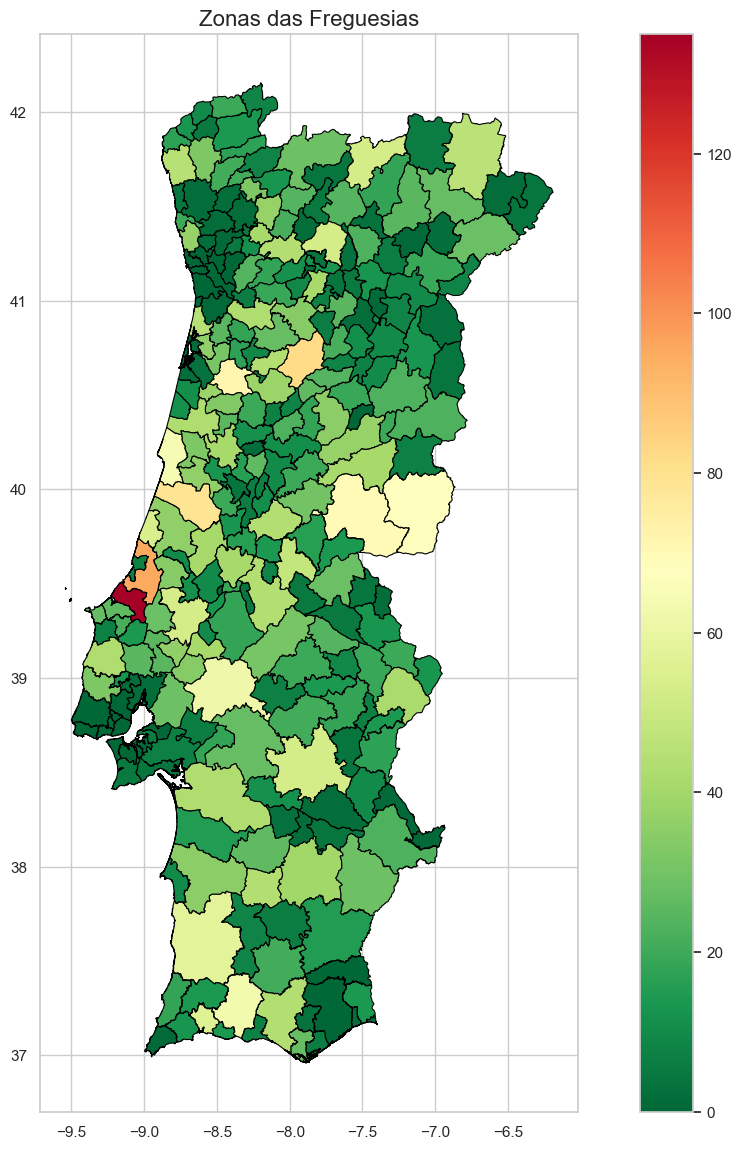

In [28]:
# Configurar a figura e o eixo
fig, ax = plt.subplots(figsize=(16, 14))

# Plotar o mapa das freguesias
Freguesias_com_clusters.plot(column='Cluster_0', cmap = "RdYlGn_r", linewidth=0.8, edgecolor='black', ax=ax, legend=True)

# Adicionar título
ax.set_title('Zonas das Freguesias', fontsize=16)

# Exibir o mapa
plt.show()

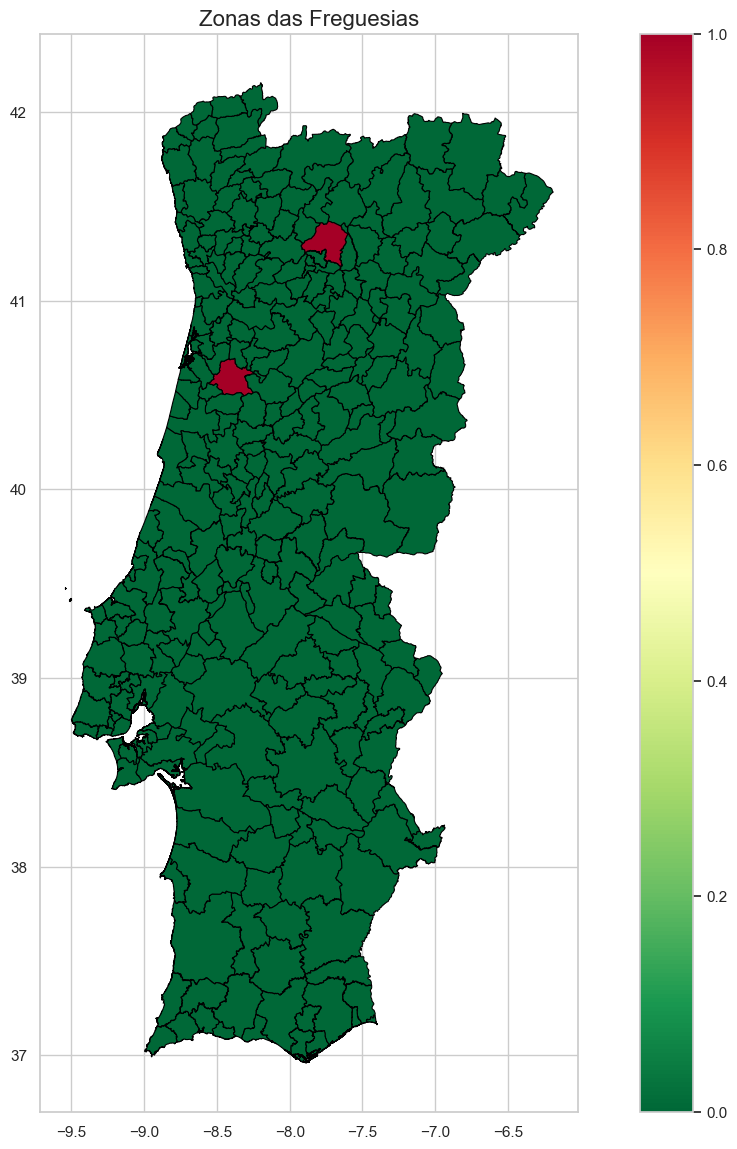

In [29]:
# Configurar a figura e o eixo
fig, ax = plt.subplots(figsize=(16, 14))

# Plotar o mapa das freguesias
Freguesias_com_clusters.plot(column='Cluster_1', cmap = "RdYlGn_r", linewidth=0.8, edgecolor='black', ax=ax, legend=True)

# Adicionar título
ax.set_title('Zonas das Freguesias', fontsize=16)

# Exibir o mapa
plt.show()

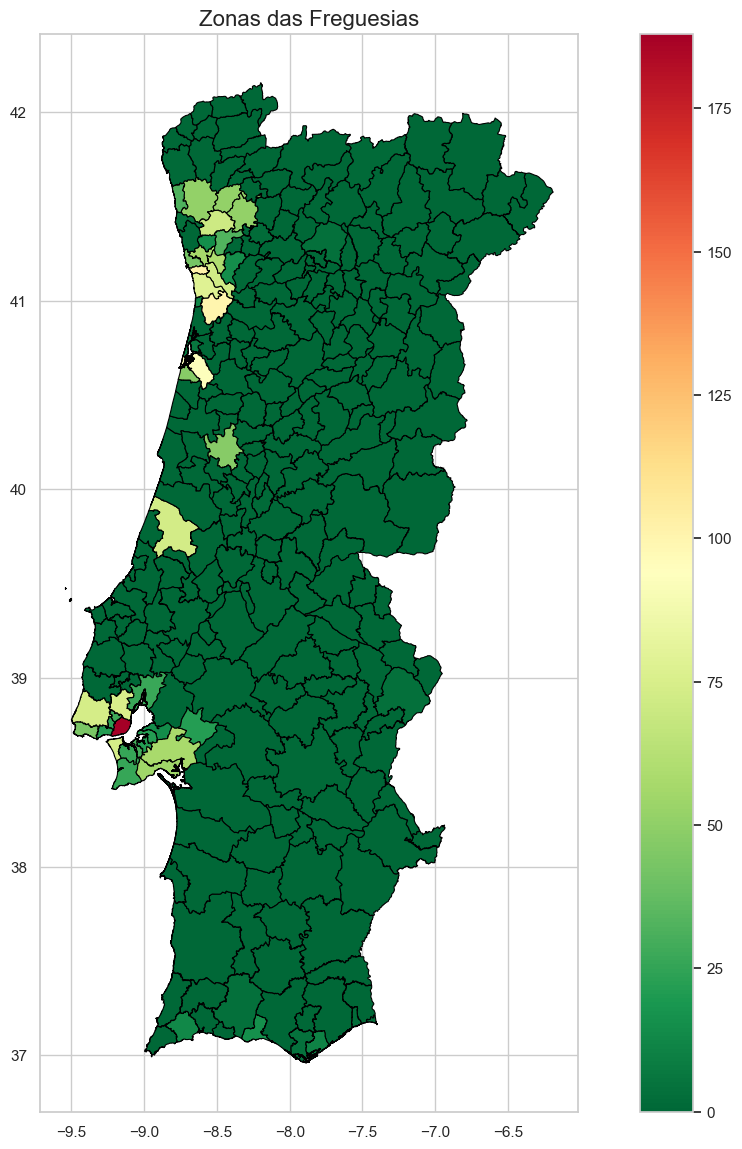

In [30]:
# Configurar a figura e o eixo
fig, ax = plt.subplots(figsize=(16, 14))

# Plotar o mapa das freguesias
Freguesias_com_clusters.plot(column='Cluster_2', cmap = "RdYlGn_r", linewidth=0.8, edgecolor='black', ax=ax, legend=True)

# Adicionar título
ax.set_title('Zonas das Freguesias', fontsize=16)

# Exibir o mapa
plt.show()